In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input/LANL-Earthquake-Prediction'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/LANL-Earthquake-Prediction/sample_submission.csv
/kaggle/input/LANL-Earthquake-Prediction/train.csv
/kaggle/input/LANL-Earthquake-Prediction/test/seg_fb8af5.csv
/kaggle/input/LANL-Earthquake-Prediction/test/seg_a35c82.csv
/kaggle/input/LANL-Earthquake-Prediction/test/seg_cec2f2.csv
/kaggle/input/LANL-Earthquake-Prediction/test/seg_176542.csv
/kaggle/input/LANL-Earthquake-Prediction/test/seg_9c3d6a.csv
/kaggle/input/LANL-Earthquake-Prediction/test/seg_9e61da.csv
/kaggle/input/LANL-Earthquake-Prediction/test/seg_afadfb.csv
/kaggle/input/LANL-Earthquake-Prediction/test/seg_986976.csv
/kaggle/input/LANL-Earthquake-Prediction/test/seg_ceab44.csv
/kaggle/input/LANL-Earthquake-Prediction/test/seg_272a47.csv
/kaggle/input/LANL-Earthquake-Prediction/test/seg_5ef47e.csv
/kaggle/input/LANL-Earthquake-Prediction/test/seg_69787a.csv
/kaggle/input/LANL-Earthquake-Prediction/test/seg_9f6315.csv
/kaggle/input/LANL-Earthquake-Prediction/test/seg_6f2222.csv
/kaggle/input/LANL-Earthquake-Pr

### All the code has been ran on kaggle kernel



In [3]:
print(os.listdir("../input/LANL-Earthquake-Prediction"))

['sample_submission.csv', 'train.csv', 'test']


In [4]:
test_folder_files = os.listdir("../input/LANL-Earthquake-Prediction/test")
print(test_folder_files[:10])  # print first 10
print("\nNumber of files in the test folder", len(test_folder_files))

['seg_fb8af5.csv', 'seg_a35c82.csv', 'seg_cec2f2.csv', 'seg_176542.csv', 'seg_9c3d6a.csv', 'seg_9e61da.csv', 'seg_afadfb.csv', 'seg_986976.csv', 'seg_ceab44.csv', 'seg_272a47.csv']

Number of files in the test folder 2624


In [5]:
sample_sub = pd.read_csv('../input/LANL-Earthquake-Prediction/sample_submission.csv')
print("Submission shape", sample_sub.shape)
sample_sub.head()

Submission shape (2624, 2)


,seg_id,time_to_failure
0,seg_00030f,0
1,seg_0012b5,0
2,seg_00184e,0
3,seg_003339,0
4,seg_0042cc,0


In [6]:
import numpy as np
import pandas as pd
import os

import matplotlib.pyplot as plt
%matplotlib inline
from tqdm import tqdm_notebook
from sklearn.preprocessing import StandardScaler
from sklearn.svm import NuSVR, SVR
from sklearn.metrics import mean_absolute_error
pd.options.display.precision = 15

import lightgbm as lgb
import xgboost as xgb
import time
import datetime
from catboost import CatBoostRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold, KFold, RepeatedKFold
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import LinearRegression
import gc
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

from scipy.signal import hilbert
from scipy.signal import hann
from scipy.signal import convolve
from scipy import stats
from sklearn.kernel_ridge import KernelRidge

In [7]:
%%time
train = pd.read_csv('../input/LANL-Earthquake-Prediction/train.csv', dtype={'acoustic_data': np.int16, 'time_to_failure': np.float32})

CPU times: user 1min 42s, sys: 11.3 s, total: 1min 53s
Wall time: 3min 35s


In [8]:
train.head()

,acoustic_data,time_to_failure
0,12,1.469099998474121
1,6,1.469099998474121
2,8,1.469099998474121
3,5,1.469099998474121
4,8,1.469099998474121


In [9]:
train.shape

(629145480, 2)

## Feature Creation

In [10]:
# Create a training file with simple derived features
rows = 150_000
segments = int(np.floor(train.shape[0] / rows))

def add_trend_feature(arr, abs_values=False):
    idx = np.array(range(len(arr)))
    if abs_values:
        arr = np.abs(arr)
    lr = LinearRegression()
    lr.fit(idx.reshape(-1, 1), arr)
    return lr.coef_[0]

def classic_sta_lta(x, length_sta, length_lta):
    
    sta = np.cumsum(x ** 2)

    # Convert to float
    sta = np.require(sta, dtype=np.float)

    # Copy for LTA
    lta = sta.copy()

    # Compute the STA and the LTA
    sta[length_sta:] = sta[length_sta:] - sta[:-length_sta]
    sta /= length_sta
    lta[length_lta:] = lta[length_lta:] - lta[:-length_lta]
    lta /= length_lta

    # Pad zeros
    sta[:length_lta - 1] = 0

    # Avoid division by zero by setting zero values to tiny float
    dtiny = np.finfo(0.0).tiny
    idx = lta < dtiny
    lta[idx] = dtiny

    return sta / lta

X_tr = pd.DataFrame(index=range(segments), dtype=np.float64)

y_tr = pd.DataFrame(index=range(segments), dtype=np.float64, columns=['time_to_failure'])

total_mean = train['acoustic_data'].mean()
total_std = train['acoustic_data'].std()
total_max = train['acoustic_data'].max()
total_min = train['acoustic_data'].min()
total_sum = train['acoustic_data'].sum()
total_abs_sum = np.abs(train['acoustic_data']).sum()

def calc_change_rate(x):
    change = (np.diff(x) / x[:-1]).values
    change = change[np.nonzero(change)[0]]
    change = change[~np.isnan(change)]
    change = change[change != -np.inf]
    change = change[change != np.inf]
    return np.mean(change)

for segment in tqdm_notebook(range(segments)):
    seg = train.iloc[segment*rows:segment*rows+rows]
    x = pd.Series(seg['acoustic_data'].values)
    y = seg['time_to_failure'].values[-1]
    
    y_tr.loc[segment, 'time_to_failure'] = y
    X_tr.loc[segment, 'mean'] = x.mean()
    X_tr.loc[segment, 'std'] = x.std()
    X_tr.loc[segment, 'max'] = x.max()
    X_tr.loc[segment, 'min'] = x.min()
    
    X_tr.loc[segment, 'mean_change_abs'] = np.mean(np.diff(x))
    X_tr.loc[segment, 'mean_change_rate'] = calc_change_rate(x)
    X_tr.loc[segment, 'abs_max'] = np.abs(x).max()
    X_tr.loc[segment, 'abs_min'] = np.abs(x).min()
    
    X_tr.loc[segment, 'std_first_50000'] = x[:50000].std()
    X_tr.loc[segment, 'std_last_50000'] = x[-50000:].std()
    X_tr.loc[segment, 'std_first_10000'] = x[:10000].std()
    X_tr.loc[segment, 'std_last_10000'] = x[-10000:].std()
    
    X_tr.loc[segment, 'avg_first_50000'] = x[:50000].mean()
    X_tr.loc[segment, 'avg_last_50000'] = x[-50000:].mean()
    X_tr.loc[segment, 'avg_first_10000'] = x[:10000].mean()
    X_tr.loc[segment, 'avg_last_10000'] = x[-10000:].mean()
    
    X_tr.loc[segment, 'min_first_50000'] = x[:50000].min()
    X_tr.loc[segment, 'min_last_50000'] = x[-50000:].min()
    X_tr.loc[segment, 'min_first_10000'] = x[:10000].min()
    X_tr.loc[segment, 'min_last_10000'] = x[-10000:].min()
    
    X_tr.loc[segment, 'max_first_50000'] = x[:50000].max()
    X_tr.loc[segment, 'max_last_50000'] = x[-50000:].max()
    X_tr.loc[segment, 'max_first_10000'] = x[:10000].max()
    X_tr.loc[segment, 'max_last_10000'] = x[-10000:].max()
    
    X_tr.loc[segment, 'max_to_min'] = x.max() / np.abs(x.min())
    X_tr.loc[segment, 'max_to_min_diff'] = x.max() - np.abs(x.min())
    X_tr.loc[segment, 'count_big'] = len(x[np.abs(x) > 500])
    X_tr.loc[segment, 'sum'] = x.sum()
    
    X_tr.loc[segment, 'mean_change_rate_first_50000'] = calc_change_rate(x[:50000])
    X_tr.loc[segment, 'mean_change_rate_last_50000'] = calc_change_rate(x[-50000:])
    X_tr.loc[segment, 'mean_change_rate_first_10000'] = calc_change_rate(x[:10000])
    X_tr.loc[segment, 'mean_change_rate_last_10000'] = calc_change_rate(x[-10000:])
    
    X_tr.loc[segment, 'q95'] = np.quantile(x, 0.95)
    X_tr.loc[segment, 'q99'] = np.quantile(x, 0.99)
    X_tr.loc[segment, 'q05'] = np.quantile(x, 0.05)
    X_tr.loc[segment, 'q01'] = np.quantile(x, 0.01)
    
    X_tr.loc[segment, 'abs_q95'] = np.quantile(np.abs(x), 0.95)
    X_tr.loc[segment, 'abs_q99'] = np.quantile(np.abs(x), 0.99)
    X_tr.loc[segment, 'abs_q05'] = np.quantile(np.abs(x), 0.05)
    X_tr.loc[segment, 'abs_q01'] = np.quantile(np.abs(x), 0.01)
    
    X_tr.loc[segment, 'trend'] = add_trend_feature(x)
    X_tr.loc[segment, 'abs_trend'] = add_trend_feature(x, abs_values=True)
    X_tr.loc[segment, 'abs_mean'] = np.abs(x).mean()
    X_tr.loc[segment, 'abs_std'] = np.abs(x).std()
    
    X_tr.loc[segment, 'mad'] = x.mad()
    X_tr.loc[segment, 'kurt'] = x.kurtosis()
    X_tr.loc[segment, 'skew'] = x.skew()
    X_tr.loc[segment, 'med'] = x.median()
    
    X_tr.loc[segment, 'Hilbert_mean'] = np.abs(hilbert(x)).mean()
    X_tr.loc[segment, 'Hann_window_mean'] = (convolve(x, hann(150), mode='same') / sum(hann(150))).mean()
    X_tr.loc[segment, 'classic_sta_lta1_mean'] = classic_sta_lta(x, 500, 10000).mean()
    X_tr.loc[segment, 'classic_sta_lta2_mean'] = classic_sta_lta(x, 5000, 100000).mean()
    X_tr.loc[segment, 'classic_sta_lta3_mean'] = classic_sta_lta(x, 3333, 6666).mean()
    X_tr.loc[segment, 'classic_sta_lta4_mean'] = classic_sta_lta(x, 10000, 25000).mean()
    X_tr.loc[segment, 'classic_sta_lta5_mean'] = classic_sta_lta(x, 50, 1000).mean()
    X_tr.loc[segment, 'classic_sta_lta6_mean'] = classic_sta_lta(x, 100, 5000).mean()
    X_tr.loc[segment, 'classic_sta_lta7_mean'] = classic_sta_lta(x, 333, 666).mean()
    X_tr.loc[segment, 'classic_sta_lta8_mean'] = classic_sta_lta(x, 4000, 10000).mean()
    X_tr.loc[segment, 'Moving_average_700_mean'] = x.rolling(window=700).mean().mean(skipna=True)
    ewma = pd.Series.ewm
    X_tr.loc[segment, 'exp_Moving_average_300_mean'] = (ewma(x, span=300).mean()).mean(skipna=True)
    X_tr.loc[segment, 'exp_Moving_average_3000_mean'] = ewma(x, span=3000).mean().mean(skipna=True)
    X_tr.loc[segment, 'exp_Moving_average_30000_mean'] = ewma(x, span=30000).mean().mean(skipna=True)
    no_of_std = 3
    X_tr.loc[segment, 'MA_700MA_std_mean'] = x.rolling(window=700).std().mean()
    X_tr.loc[segment,'MA_700MA_BB_high_mean'] = (X_tr.loc[segment, 'Moving_average_700_mean'] + no_of_std * X_tr.loc[segment, 'MA_700MA_std_mean']).mean()
    X_tr.loc[segment,'MA_700MA_BB_low_mean'] = (X_tr.loc[segment, 'Moving_average_700_mean'] - no_of_std * X_tr.loc[segment, 'MA_700MA_std_mean']).mean()
    X_tr.loc[segment, 'MA_400MA_std_mean'] = x.rolling(window=400).std().mean()
    X_tr.loc[segment,'MA_400MA_BB_high_mean'] = (X_tr.loc[segment, 'Moving_average_700_mean'] + no_of_std * X_tr.loc[segment, 'MA_400MA_std_mean']).mean()
    X_tr.loc[segment,'MA_400MA_BB_low_mean'] = (X_tr.loc[segment, 'Moving_average_700_mean'] - no_of_std * X_tr.loc[segment, 'MA_400MA_std_mean']).mean()
    X_tr.loc[segment, 'MA_1000MA_std_mean'] = x.rolling(window=1000).std().mean()
    X_tr.drop('Moving_average_700_mean', axis=1, inplace=True)
    
    X_tr.loc[segment, 'iqr'] = np.subtract(*np.percentile(x, [75, 25]))
    X_tr.loc[segment, 'q999'] = np.quantile(x,0.999)
    X_tr.loc[segment, 'q001'] = np.quantile(x,0.001)
    X_tr.loc[segment, 'ave10'] = stats.trim_mean(x, 0.1)

    for windows in [10, 100, 1000]:
        x_roll_std = x.rolling(windows).std().dropna().values
        x_roll_mean = x.rolling(windows).mean().dropna().values
        
        X_tr.loc[segment, 'ave_roll_std_' + str(windows)] = x_roll_std.mean()
        X_tr.loc[segment, 'std_roll_std_' + str(windows)] = x_roll_std.std()
        X_tr.loc[segment, 'max_roll_std_' + str(windows)] = x_roll_std.max()
        X_tr.loc[segment, 'min_roll_std_' + str(windows)] = x_roll_std.min()
        X_tr.loc[segment, 'q01_roll_std_' + str(windows)] = np.quantile(x_roll_std, 0.01)
        X_tr.loc[segment, 'q05_roll_std_' + str(windows)] = np.quantile(x_roll_std, 0.05)
        X_tr.loc[segment, 'q95_roll_std_' + str(windows)] = np.quantile(x_roll_std, 0.95)
        X_tr.loc[segment, 'q99_roll_std_' + str(windows)] = np.quantile(x_roll_std, 0.99)
        X_tr.loc[segment, 'av_change_abs_roll_std_' + str(windows)] = np.mean(np.diff(x_roll_std))
        X_tr.loc[segment, 'av_change_rate_roll_std_' + str(windows)] = np.mean(np.nonzero((np.diff(x_roll_std) / x_roll_std[:-1]))[0])
        X_tr.loc[segment, 'abs_max_roll_std_' + str(windows)] = np.abs(x_roll_std).max()
        
        X_tr.loc[segment, 'ave_roll_mean_' + str(windows)] = x_roll_mean.mean()
        X_tr.loc[segment, 'std_roll_mean_' + str(windows)] = x_roll_mean.std()
        X_tr.loc[segment, 'max_roll_mean_' + str(windows)] = x_roll_mean.max()
        X_tr.loc[segment, 'min_roll_mean_' + str(windows)] = x_roll_mean.min()
        X_tr.loc[segment, 'q01_roll_mean_' + str(windows)] = np.quantile(x_roll_mean, 0.01)
        X_tr.loc[segment, 'q05_roll_mean_' + str(windows)] = np.quantile(x_roll_mean, 0.05)
        X_tr.loc[segment, 'q95_roll_mean_' + str(windows)] = np.quantile(x_roll_mean, 0.95)
        X_tr.loc[segment, 'q99_roll_mean_' + str(windows)] = np.quantile(x_roll_mean, 0.99)
        X_tr.loc[segment, 'av_change_abs_roll_mean_' + str(windows)] = np.mean(np.diff(x_roll_mean))
        X_tr.loc[segment, 'av_change_rate_roll_mean_' + str(windows)] = np.mean(np.nonzero((np.diff(x_roll_mean) / x_roll_mean[:-1]))[0])
        X_tr.loc[segment, 'abs_max_roll_mean_' + str(windows)] = np.abs(x_roll_mean).max()

  0%|          | 0/4194 [00:00<?, ?it/s]

In [11]:
X_tr.shape

(4194, 138)

In [12]:
X_tr.head()

,mean,std,max,min,mean_change_abs,mean_change_rate,abs_max,abs_min,std_first_50000,std_last_50000,...,std_roll_mean_1000,max_roll_mean_1000,min_roll_mean_1000,q01_roll_mean_1000,q05_roll_mean_1000,q95_roll_mean_1000,q99_roll_mean_1000,av_change_abs_roll_mean_1000,av_change_rate_roll_mean_1000,abs_max_roll_mean_1000
0,4.884113333333334,5.101106130606765,104.0,-98.0,-0.000080000533337,0.036138006830485,104.0,0.0,6.488551888989741,3.664663420228340,...,0.295714650592636,5.629,3.896,4.072,4.379,5.338,5.484,-0.000001704697987,74222.343442640820285,5.629
1,4.725766666666667,6.588823781946801,181.0,-154.0,0.000000000000000,0.022628810812312,181.0,0.0,7.305232697765033,5.493070500263983,...,0.231586699576737,5.667,3.412,4.233,4.345,5.066,5.223,-0.000002449664430,74364.426477527638781,5.667
2,4.906393333333333,6.967397033524431,140.0,-106.0,-0.000013333422223,0.023744293687586,140.0,0.0,6.104836457315087,8.603695613814120,...,0.267011771793293,5.957,4.055,4.239,4.446,5.344,5.486,0.000001140939597,74594.984584474615986,5.957
3,4.902240000000000,6.922305187180113,197.0,-199.0,0.000000000000000,0.042462106917742,199.0,0.0,6.238109475682244,5.652441899780007,...,0.266699817775971,5.858,3.722,4.304,4.433,5.317,5.453,-0.000002550335570,74333.143622613599291,5.858
4,4.908720000000000,7.301110189758817,145.0,-126.0,-0.000006666711111,0.038659029321996,145.0,0.0,5.323829516204886,7.694506067635043,...,0.228004751350508,6.078,3.918,4.434,4.543,5.306,5.491,0.000001550335570,74428.435968884237809,6.078


In [13]:
X_tr.info(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4194 entries, 0 to 4193
Data columns (total 138 columns):
 #    Column                         Dtype  
---   ------                         -----  
 0    mean                           float64
 1    std                            float64
 2    max                            float64
 3    min                            float64
 4    mean_change_abs                float64
 5    mean_change_rate               float64
 6    abs_max                        float64
 7    abs_min                        float64
 8    std_first_50000                float64
 9    std_last_50000                 float64
 10   std_first_10000                float64
 11   std_last_10000                 float64
 12   avg_first_50000                float64
 13   avg_last_50000                 float64
 14   avg_first_10000                float64
 15   avg_last_10000                 float64
 16   min_first_50000                float64
 17   min_last_50000                 

In [14]:
np.abs(X_tr.corrwith(y_tr['time_to_failure'])).sort_values(ascending=False).head(20)

q05_roll_std_100                0.648824447085235
q01_roll_std_100                0.644797095583286
q05_roll_std_10                 0.643123220300553
q01_roll_std_10                 0.635263713453376
q05_roll_std_1000               0.614482273761357
q01_roll_std_1000               0.603691188926765
min_roll_std_1000               0.544294240127082
mean_change_rate                0.538690888444172
mean_change_rate_last_50000     0.508632611830098
mean_change_rate_first_50000    0.508157804665917
iqr                             0.506994140262580
classic_sta_lta6_mean           0.444735193498527
q95_roll_std_10                 0.439754146577985
q95_roll_mean_10                0.439483461929961
q95_roll_std_100                0.433791697887346
q05_roll_mean_10                0.428967215266466
q95_roll_std_1000               0.426868127937231
q95                             0.423118153167926
mean_change_rate_first_10000    0.420710371350546
mean_change_rate_last_10000     0.418333378557874


plt.figure(figsize=(44, 24))
cols = list(np.abs(X_tr.corrwith(y_tr['time_to_failure'])).sort_values(ascending=False).head(24).index)
for i, col in enumerate(cols):
    plt.subplot(6, 4, i + 1)
    plt.plot(X_tr[col], color='blue')
    plt.title(col)
    ax1.set_ylabel(col, color='b')

    ax2 = ax1.twinx()
    plt.plot(y_tr, color='g')
    ax2.set_ylabel('time_to_failure', color='g')
    plt.legend([col, 'time_to_failure'], loc=(0.875, 0.9))
    plt.grid(False)

Text(0.5, 1.0, 'Absolute mean')

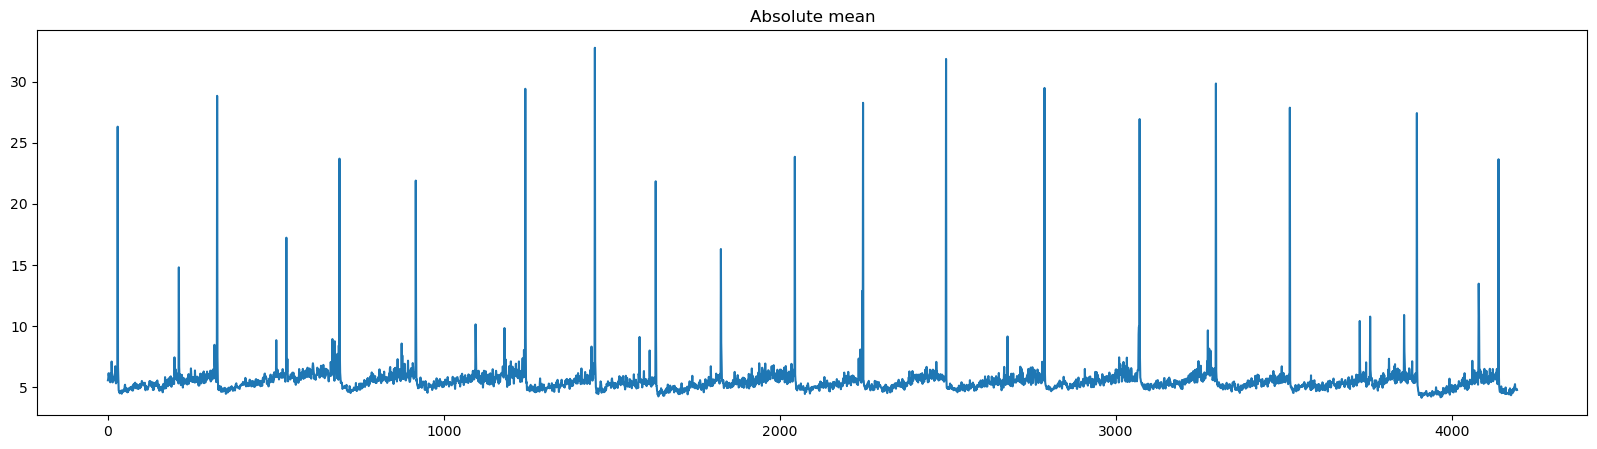

In [15]:
plt.figure(figsize=(20,5))
X_tr['abs_mean'].plot()
plt.title('Absolute mean')



In [16]:
means_dict = {}
for col in X_tr.columns:
    if X_tr[col].isnull().any():
        print(col)
        mean_value = X_tr.loc[X_tr[col] != -np.inf, col].mean()
        X_tr.loc[X_tr[col] == -np.inf, col] = mean_value
        X_tr[col] = X_tr[col].fillna(mean_value)
        means_dict[col] = mean_value

classic_sta_lta5_mean
classic_sta_lta7_mean


In [17]:
scaler = StandardScaler()
scaler.fit(X_tr)
X_train_scaled = pd.DataFrame(scaler.transform(X_tr), columns=X_tr.columns)

In [18]:
print(os.listdir("../input/LANL-Earthquake-Prediction/"))


['sample_submission.csv', 'train.csv', 'test']


  0%|          | 0/2624 [00:00<?, ?it/s]

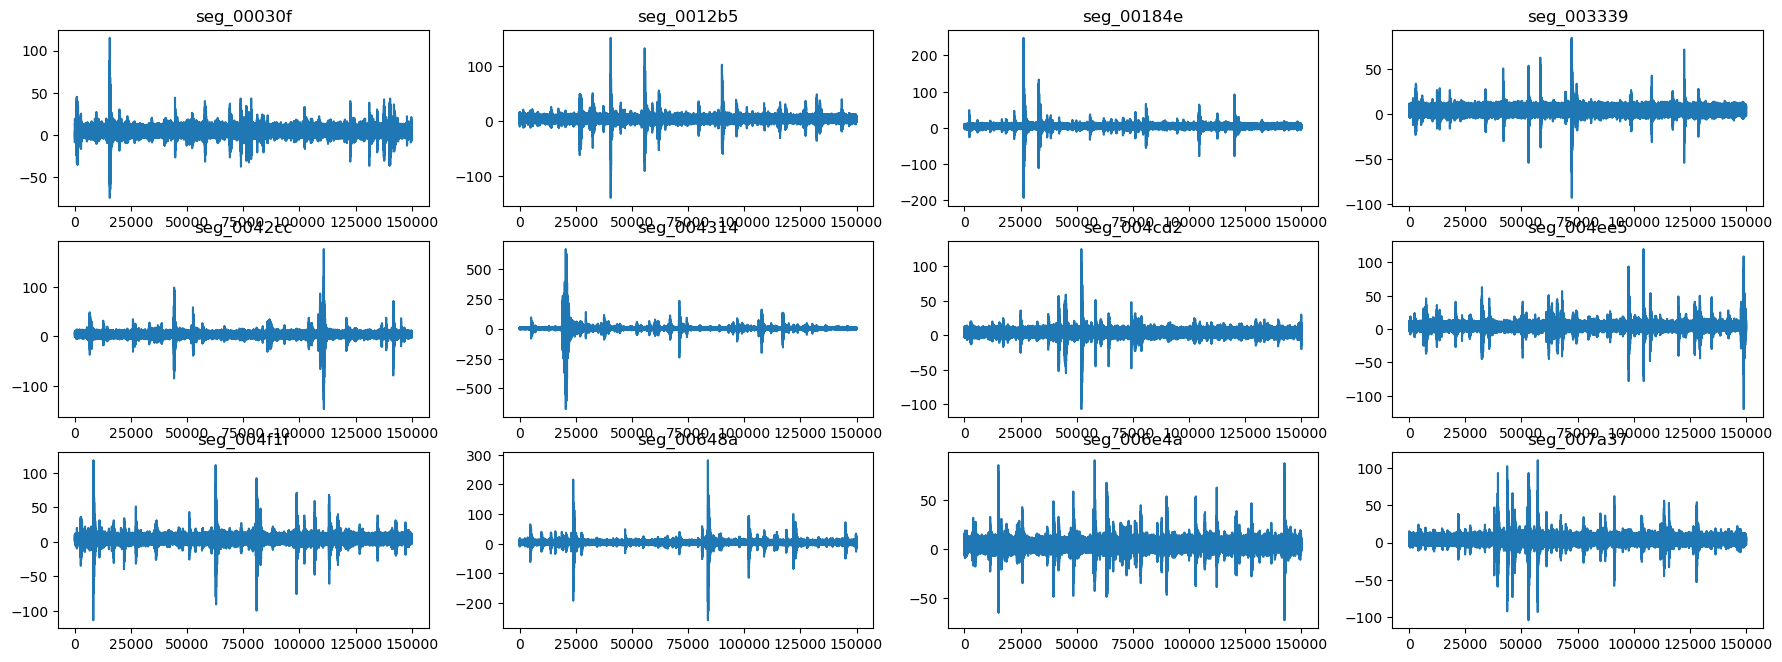

In [19]:
submission = pd.read_csv('../input/LANL-Earthquake-Prediction/sample_submission.csv', index_col='seg_id')
X_test = pd.DataFrame(columns=X_tr.columns, dtype=np.float64, index=submission.index)
plt.figure(figsize=(22, 16))

for i, seg_id in enumerate(tqdm_notebook(X_test.index)):
    seg = pd.read_csv('../input/LANL-Earthquake-Prediction/test/' + seg_id + '.csv')
    
    x = pd.Series(seg['acoustic_data'].values)
    X_test.loc[seg_id, 'mean'] = x.mean()
    X_test.loc[seg_id, 'std'] = x.std()
    X_test.loc[seg_id, 'max'] = x.max()
    X_test.loc[seg_id, 'min'] = x.min()
        
    X_test.loc[seg_id, 'mean_change_abs'] = np.mean(np.diff(x))
    X_test.loc[seg_id, 'mean_change_rate'] = calc_change_rate(x)
    X_test.loc[seg_id, 'abs_max'] = np.abs(x).max()
    X_test.loc[seg_id, 'abs_min'] = np.abs(x).min()
    
    X_test.loc[seg_id, 'std_first_50000'] = x[:50000].std()
    X_test.loc[seg_id, 'std_last_50000'] = x[-50000:].std()
    X_test.loc[seg_id, 'std_first_10000'] = x[:10000].std()
    X_test.loc[seg_id, 'std_last_10000'] = x[-10000:].std()
    
    X_test.loc[seg_id, 'avg_first_50000'] = x[:50000].mean()
    X_test.loc[seg_id, 'avg_last_50000'] = x[-50000:].mean()
    X_test.loc[seg_id, 'avg_first_10000'] = x[:10000].mean()
    X_test.loc[seg_id, 'avg_last_10000'] = x[-10000:].mean()
    
    X_test.loc[seg_id, 'min_first_50000'] = x[:50000].min()
    X_test.loc[seg_id, 'min_last_50000'] = x[-50000:].min()
    X_test.loc[seg_id, 'min_first_10000'] = x[:10000].min()
    X_test.loc[seg_id, 'min_last_10000'] = x[-10000:].min()
    
    X_test.loc[seg_id, 'max_first_50000'] = x[:50000].max()
    X_test.loc[seg_id, 'max_last_50000'] = x[-50000:].max()
    X_test.loc[seg_id, 'max_first_10000'] = x[:10000].max()
    X_test.loc[seg_id, 'max_last_10000'] = x[-10000:].max()
    
    X_test.loc[seg_id, 'max_to_min'] = x.max() / np.abs(x.min())
    X_test.loc[seg_id, 'max_to_min_diff'] = x.max() - np.abs(x.min())
    X_test.loc[seg_id, 'count_big'] = len(x[np.abs(x) > 500])
    X_test.loc[seg_id, 'sum'] = x.sum()
    
    X_test.loc[seg_id, 'mean_change_rate_first_50000'] = calc_change_rate(x[:50000])
    X_test.loc[seg_id, 'mean_change_rate_last_50000'] = calc_change_rate(x[-50000:])
    X_test.loc[seg_id, 'mean_change_rate_first_10000'] = calc_change_rate(x[:10000])
    X_test.loc[seg_id, 'mean_change_rate_last_10000'] = calc_change_rate(x[-10000:])
    
    X_test.loc[seg_id, 'q95'] = np.quantile(x,0.95)
    X_test.loc[seg_id, 'q99'] = np.quantile(x,0.99)
    X_test.loc[seg_id, 'q05'] = np.quantile(x,0.05)
    X_test.loc[seg_id, 'q01'] = np.quantile(x,0.01)
    
    X_test.loc[seg_id, 'abs_q95'] = np.quantile(np.abs(x), 0.95)
    X_test.loc[seg_id, 'abs_q99'] = np.quantile(np.abs(x), 0.99)
    X_test.loc[seg_id, 'abs_q05'] = np.quantile(np.abs(x), 0.05)
    X_test.loc[seg_id, 'abs_q01'] = np.quantile(np.abs(x), 0.01)
    
    X_test.loc[seg_id, 'trend'] = add_trend_feature(x)
    X_test.loc[seg_id, 'abs_trend'] = add_trend_feature(x, abs_values=True)
    X_test.loc[seg_id, 'abs_mean'] = np.abs(x).mean()
    X_test.loc[seg_id, 'abs_std'] = np.abs(x).std()
    
    X_test.loc[seg_id, 'mad'] = x.mad()
    X_test.loc[seg_id, 'kurt'] = x.kurtosis()
    X_test.loc[seg_id, 'skew'] = x.skew()
    X_test.loc[seg_id, 'med'] = x.median()
    
    X_test.loc[seg_id, 'Hilbert_mean'] = np.abs(hilbert(x)).mean()
    X_test.loc[seg_id, 'Hann_window_mean'] = (convolve(x, hann(150), mode='same') / sum(hann(150))).mean()
    X_test.loc[seg_id, 'classic_sta_lta1_mean'] = classic_sta_lta(x, 500, 10000).mean()
    X_test.loc[seg_id, 'classic_sta_lta2_mean'] = classic_sta_lta(x, 5000, 100000).mean()
    X_test.loc[seg_id, 'classic_sta_lta3_mean'] = classic_sta_lta(x, 3333, 6666).mean()
    X_test.loc[seg_id, 'classic_sta_lta4_mean'] = classic_sta_lta(x, 10000, 25000).mean()
    X_test.loc[seg_id, 'classic_sta_lta5_mean'] = classic_sta_lta(x, 50, 1000).mean()
    X_test.loc[seg_id, 'classic_sta_lta6_mean'] = classic_sta_lta(x, 100, 5000).mean()
    X_test.loc[seg_id, 'classic_sta_lta7_mean'] = classic_sta_lta(x, 333, 666).mean()
    X_test.loc[seg_id, 'classic_sta_lta8_mean'] = classic_sta_lta(x, 4000, 10000).mean()
    X_test.loc[seg_id, 'Moving_average_700_mean'] = x.rolling(window=700).mean().mean(skipna=True)
    ewma = pd.Series.ewm
    X_test.loc[seg_id, 'exp_Moving_average_300_mean'] = (ewma(x, span=300).mean()).mean(skipna=True)
    X_test.loc[seg_id, 'exp_Moving_average_3000_mean'] = ewma(x, span=3000).mean().mean(skipna=True)
    X_test.loc[seg_id, 'exp_Moving_average_30000_mean'] = ewma(x, span=30000).mean().mean(skipna=True)
    no_of_std = 3
    X_test.loc[seg_id, 'MA_700MA_std_mean'] = x.rolling(window=700).std().mean()
    X_test.loc[seg_id,'MA_700MA_BB_high_mean'] = (X_test.loc[seg_id, 'Moving_average_700_mean'] + no_of_std * X_test.loc[seg_id, 'MA_700MA_std_mean']).mean()
    X_test.loc[seg_id,'MA_700MA_BB_low_mean'] = (X_test.loc[seg_id, 'Moving_average_700_mean'] - no_of_std * X_test.loc[seg_id, 'MA_700MA_std_mean']).mean()
    X_test.loc[seg_id, 'MA_400MA_std_mean'] = x.rolling(window=400).std().mean()
    X_test.loc[seg_id,'MA_400MA_BB_high_mean'] = (X_test.loc[seg_id, 'Moving_average_700_mean'] + no_of_std * X_test.loc[seg_id, 'MA_400MA_std_mean']).mean()
    X_test.loc[seg_id,'MA_400MA_BB_low_mean'] = (X_test.loc[seg_id, 'Moving_average_700_mean'] - no_of_std * X_test.loc[seg_id, 'MA_400MA_std_mean']).mean()
    X_test.loc[seg_id, 'MA_1000MA_std_mean'] = x.rolling(window=1000).std().mean()
    X_test.drop('Moving_average_700_mean', axis=1, inplace=True)
    
    X_test.loc[seg_id, 'iqr'] = np.subtract(*np.percentile(x, [75, 25]))
    X_test.loc[seg_id, 'q999'] = np.quantile(x,0.999)
    X_test.loc[seg_id, 'q001'] = np.quantile(x,0.001)
    X_test.loc[seg_id, 'ave10'] = stats.trim_mean(x, 0.1)
    
    for windows in [10, 100, 1000]:
        x_roll_std = x.rolling(windows).std().dropna().values
        x_roll_mean = x.rolling(windows).mean().dropna().values
        
        X_test.loc[seg_id, 'ave_roll_std_' + str(windows)] = x_roll_std.mean()
        X_test.loc[seg_id, 'std_roll_std_' + str(windows)] = x_roll_std.std()
        X_test.loc[seg_id, 'max_roll_std_' + str(windows)] = x_roll_std.max()
        X_test.loc[seg_id, 'min_roll_std_' + str(windows)] = x_roll_std.min()
        X_test.loc[seg_id, 'q01_roll_std_' + str(windows)] = np.quantile(x_roll_std, 0.01)
        X_test.loc[seg_id, 'q05_roll_std_' + str(windows)] = np.quantile(x_roll_std, 0.05)
        X_test.loc[seg_id, 'q95_roll_std_' + str(windows)] = np.quantile(x_roll_std, 0.95)
        X_test.loc[seg_id, 'q99_roll_std_' + str(windows)] = np.quantile(x_roll_std, 0.99)
        X_test.loc[seg_id, 'av_change_abs_roll_std_' + str(windows)] = np.mean(np.diff(x_roll_std))
        X_test.loc[seg_id, 'av_change_rate_roll_std_' + str(windows)] = np.mean(np.nonzero((np.diff(x_roll_std) / x_roll_std[:-1]))[0])
        X_test.loc[seg_id, 'abs_max_roll_std_' + str(windows)] = np.abs(x_roll_std).max()
        
        X_test.loc[seg_id, 'ave_roll_mean_' + str(windows)] = x_roll_mean.mean()
        X_test.loc[seg_id, 'std_roll_mean_' + str(windows)] = x_roll_mean.std()
        X_test.loc[seg_id, 'max_roll_mean_' + str(windows)] = x_roll_mean.max()
        X_test.loc[seg_id, 'min_roll_mean_' + str(windows)] = x_roll_mean.min()
        X_test.loc[seg_id, 'q01_roll_mean_' + str(windows)] = np.quantile(x_roll_mean, 0.01)
        X_test.loc[seg_id, 'q05_roll_mean_' + str(windows)] = np.quantile(x_roll_mean, 0.05)
        X_test.loc[seg_id, 'q95_roll_mean_' + str(windows)] = np.quantile(x_roll_mean, 0.95)
        X_test.loc[seg_id, 'q99_roll_mean_' + str(windows)] = np.quantile(x_roll_mean, 0.99)
        X_test.loc[seg_id, 'av_change_abs_roll_mean_' + str(windows)] = np.mean(np.diff(x_roll_mean))
        X_test.loc[seg_id, 'av_change_rate_roll_mean_' + str(windows)] = np.mean(np.nonzero((np.diff(x_roll_mean) / x_roll_mean[:-1]))[0])
        X_test.loc[seg_id, 'abs_max_roll_mean_' + str(windows)] = np.abs(x_roll_mean).max()
    
    if i < 12:
        plt.subplot(6, 4, i + 1)
        plt.plot(seg['acoustic_data'])
        plt.title(seg_id)

for col in X_test.columns:
    if X_test[col].isnull().any():
        X_test.loc[X_test[col] == -np.inf, col] = means_dict[col]
        X_test[col] = X_test[col].fillna(means_dict[col])
        
X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)

In [20]:
X_train_scaled.shape

(4194, 138)

In [21]:
y_tr.shape

(4194, 1)

## Below Experiment 

 

### Feature Selection with RFE top 50 feature selection

- Catboost
- ligthGBM
- GRU


### Feature Selection with BorutaShap

- Catboost
- lightgbm
- GRU


### K-fold cross validation 
### HO

In [22]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error
from catboost import CatBoostRegressor
import lightgbm as lgb
from lightgbm import LGBMRegressor
import xgboost as xgb
import lightgbm as lgb
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

from tqdm import tqdm
warnings.filterwarnings("ignore")

In [23]:
X_train_cb_base,X_test_cb_base,y_train_cb_base,y_test_cb_base = train_test_split(X_train_scaled,y_tr,train_size=0.8,random_state= 42)

In [24]:
X_train_cb_base.shape,X_test_cb_base.shape,y_train_cb_base.shape,y_test_cb_base.shape

((3355, 138), (839, 138), (3355, 1), (839, 1))

In [25]:
type(X_train_cb_base),type(X_test_cb_base),type(y_train_cb_base),type(y_test_cb_base)

(pandas.core.frame.DataFrame,
 pandas.core.frame.DataFrame,
 pandas.core.frame.DataFrame,
 pandas.core.frame.DataFrame)

## CatBoost Implementation

In [26]:
#build model
cat_model_basic = CatBoostRegressor(loss_function='MAE',random_state=42)
# Fit model 
cat_model_basic.fit( X_train_cb_base, y_train_cb_base,
               eval_set=(X_test_cb_base, y_test_cb_base),
               plot=True,
              )

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 2.9901672	test: 2.9958005	best: 2.9958005 (0)	total: 82ms	remaining: 1m 21s
1:	learn: 2.9466991	test: 2.9542854	best: 2.9542854 (1)	total: 98.6ms	remaining: 49.2s
2:	learn: 2.9026463	test: 2.9133804	best: 2.9133804 (2)	total: 115ms	remaining: 38.2s
3:	learn: 2.8610991	test: 2.8743668	best: 2.8743668 (3)	total: 134ms	remaining: 33.3s
4:	learn: 2.8228966	test: 2.8371662	best: 2.8371662 (4)	total: 150ms	remaining: 29.8s
5:	learn: 2.7856327	test: 2.8012568	best: 2.8012568 (5)	total: 167ms	remaining: 27.6s
6:	learn: 2.7507945	test: 2.7671574	best: 2.7671574 (6)	total: 183ms	remaining: 25.9s
7:	learn: 2.7161569	test: 2.7333309	best: 2.7333309 (7)	total: 198ms	remaining: 24.6s
8:	learn: 2.6835512	test: 2.7015828	best: 2.7015828 (8)	total: 215ms	remaining: 23.7s
9:	learn: 2.6542830	test: 2.6731021	best: 2.6731021 (9)	total: 231ms	remaining: 22.8s
10:	learn: 2.6250651	test: 2.6456176	best: 2.6456176 (10)	total: 247ms	remaining: 22.2s
11:	learn: 2.5954634	test: 2.6173709	best: 2.617370

In [27]:
#type(X_train_cb_base),type(X_test_cb_base),type(y_train_cb_base),type(y_test_cb_base) cat_model_basic
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import mean_absolute_error

y_pred_cb_base =cat_model_basic.predict(X_test_cb_base)
mae_cb_base = mean_absolute_error(y_test_cb_base,y_pred_cb_base)
mape_cb_base=mean_absolute_percentage_error(y_test_cb_base,y_pred_cb_base)
print('MAE is %.5f' % mae_cb_base)
print('MAPE is %.5f' % mape_cb_base)


MAE is 2.06326
MAPE is 3.82647


In [29]:
df_feature_importance = pd.DataFrame(cat_model_basic.get_feature_importance(prettified=True))

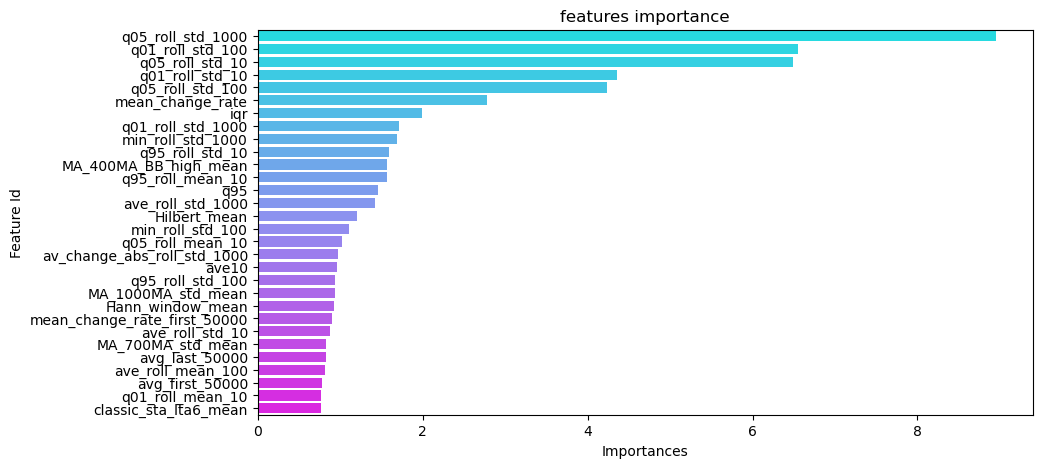

In [54]:

#plotting feature importance
plt.figure(figsize=(10,5));
feature_plot= sns.barplot(x="Importances", y="Feature Id", data=df_feature_importance[:30],palette="cool");
plt.title('features importance')
plt.savefig('FeatureImp_CB.png')

In [ ]:
#type(X_train_cb_base),type(X_test_cb_base),type(y_train_cb_base),type(y_test_cb_base) cat_model_basic

#submission['time_to_failure'] = cat_model_basic.predict(X_test_scaled)


In [ ]:

#submission.to_csv('submission.csv')
#submission.head()

## Powershp for feature selection

In [57]:
pip install powershap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 564.8/564.8 kB 16.9 MB/s eta 0:00:00
  Attempting uninstall: shap
    Found existing installation: shap 0.41.0
    Uninstalling shap-0.41.0:
      Successfully uninstalled shap-0.41.0
Note: you may need to restart the kernel to use updated packages.


In [60]:
from sklearn.feature_selection import RFE
from sklearn.model_selection import KFold
import pandas as pd
from powershap import PowerShap
from sklearn.model_selection import train_test_split


In [ ]:
#X_train_cb_base,X_test_cb_base,y_train_cb_base,y_test_cb_base = train_test_split(X_train_scaled,y_tr,train_size=0.8,random_state= 42)

In [59]:
X_train_cb_base.shape,X_test_cb_base.shape,y_train_cb_base.shape,y_test_cb_base.shape

((3355, 138), (839, 138), (3355, 1), (839, 1))

In [61]:
selector_cb = PowerShap(
    model = CatBoostRegressor(),
    automatic=True,limit_automatic=100,)
selector_cb.fit(X_train_cb_base, y_train_cb_base)


  0%|          | 0/10 [00:00<?, ?it/s]

Learning rate set to 0.059459
0:	learn: 3.5862468	test: 3.6145889	best: 3.6145889 (0)	total: 32.9ms	remaining: 32.9s
1:	learn: 3.5045049	test: 3.5395385	best: 3.5395385 (1)	total: 50.2ms	remaining: 25.1s
2:	learn: 3.4226213	test: 3.4648722	best: 3.4648722 (2)	total: 68.4ms	remaining: 22.7s
3:	learn: 3.3468504	test: 3.3989512	best: 3.3989512 (3)	total: 86ms	remaining: 21.4s
4:	learn: 3.2815841	test: 3.3415782	best: 3.3415782 (4)	total: 105ms	remaining: 20.8s
5:	learn: 3.2214266	test: 3.2898483	best: 3.2898483 (5)	total: 122ms	remaining: 20.3s
6:	learn: 3.1649805	test: 3.2409772	best: 3.2409772 (6)	total: 141ms	remaining: 20s
7:	learn: 3.1160169	test: 3.1989634	best: 3.1989634 (7)	total: 159ms	remaining: 19.8s
8:	learn: 3.0669875	test: 3.1577409	best: 3.1577409 (8)	total: 178ms	remaining: 19.6s
9:	learn: 3.0272661	test: 3.1244695	best: 3.1244695 (9)	total: 199ms	remaining: 19.7s
10:	learn: 2.9890655	test: 3.0935478	best: 3.0935478 (10)	total: 218ms	remaining: 19.6s
11:	learn: 2.9504473	t

  0%|          | 0/3 [00:00<?, ?it/s]

Learning rate set to 0.059459
0:	learn: 3.5804821	test: 3.6106838	best: 3.6106838 (0)	total: 23.3ms	remaining: 23.3s
1:	learn: 3.4922048	test: 3.5303727	best: 3.5303727 (1)	total: 39.5ms	remaining: 19.7s
2:	learn: 3.4110963	test: 3.4577396	best: 3.4577396 (2)	total: 55.6ms	remaining: 18.5s
3:	learn: 3.3353634	test: 3.3910760	best: 3.3910760 (3)	total: 71.6ms	remaining: 17.8s
4:	learn: 3.2676939	test: 3.3319876	best: 3.3319876 (4)	total: 87.7ms	remaining: 17.5s
5:	learn: 3.2083236	test: 3.2811385	best: 3.2811385 (5)	total: 104ms	remaining: 17.1s
6:	learn: 3.1527925	test: 3.2360138	best: 3.2360138 (6)	total: 120ms	remaining: 17s
7:	learn: 3.1040133	test: 3.1935254	best: 3.1935254 (7)	total: 136ms	remaining: 16.9s
8:	learn: 3.0562987	test: 3.1525843	best: 3.1525843 (8)	total: 152ms	remaining: 16.8s
9:	learn: 3.0130572	test: 3.1155159	best: 3.1155159 (9)	total: 168ms	remaining: 16.6s
10:	learn: 2.9772009	test: 3.0864150	best: 3.0864150 (10)	total: 184ms	remaining: 16.6s
11:	learn: 2.941950

PowerShap(limit_automatic=100,
          model=<catboost.core.CatBoostRegressor object at 0x7fc885455b10>)

In [62]:
selector_cb._processed_shaps_df

,impact,p_value,effect_size,power_0.01_alpha,0.99_power_its_req
q05_roll_std_10,0.276071041822433,0.0,-4.615912225693563,1.0,4.026809501024879
q05_roll_std_100,0.254736483097076,0.0,-4.642022079547163,1.0,4.013467798047728
q05_roll_std_1000,0.249763265252113,0.0,-4.742474328162824,1.0,3.963818537553850
q01_roll_std_100,0.248882055282593,0.0,-4.451527883923906,1.0,4.115311350600214
q01_roll_std_10,0.139682292938232,0.0,-3.549777524777074,1.0,4.796521665525515
...,...,...,...,...,...
max_last_10000,0.005373553372920,1.0,0.000000000000000,0.0,0.000000000000000
abs_q05,0.002952186157927,1.0,0.000000000000000,0.0,0.000000000000000
count_big,0.000399615499191,1.0,0.000000000000000,0.0,0.000000000000000
abs_min,0.000000000000000,1.0,0.000000000000000,0.0,0.000000000000000


In [63]:
#type(X_train_cb_base),type(X_test_cb_base),type(y_train_cb_base),type(y_test_cb_base) cat_model_basic
X_test_cb_base_upd=selector_cb.transform(X_test_cb_base)
#X_train_cb, X_test_cb, y_train_cb, y_test_cb

In [66]:
print(X_test_cb_base_upd.shape)
X_test_cb_base_upd.info()


(839, 10)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 839 entries, 0 to 838
Data columns (total 10 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   mean_change_rate              839 non-null    float64
 1   mean_change_rate_first_50000  839 non-null    float64
 2   q01_roll_std_10               839 non-null    float64
 3   q05_roll_std_10               839 non-null    float64
 4   q95_roll_mean_10              839 non-null    float64
 5   min_roll_std_100              839 non-null    float64
 6   q01_roll_std_100              839 non-null    float64
 7   q05_roll_std_100              839 non-null    float64
 8   q01_roll_std_1000             839 non-null    float64
 9   q05_roll_std_1000             839 non-null    float64
dtypes: float64(10)
memory usage: 65.7 KB


In [67]:
X_train_cb_base_upd = selector_cb.transform(X_train_cb_base)

In [68]:
print(X_train_cb_base_upd.shape)
X_train_cb_base_upd.info()

(3355, 10)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3355 entries, 0 to 3354
Data columns (total 10 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   mean_change_rate              3355 non-null   float64
 1   mean_change_rate_first_50000  3355 non-null   float64
 2   q01_roll_std_10               3355 non-null   float64
 3   q05_roll_std_10               3355 non-null   float64
 4   q95_roll_mean_10              3355 non-null   float64
 5   min_roll_std_100              3355 non-null   float64
 6   q01_roll_std_100              3355 non-null   float64
 7   q05_roll_std_100              3355 non-null   float64
 8   q01_roll_std_1000             3355 non-null   float64
 9   q05_roll_std_1000             3355 non-null   float64
dtypes: float64(10)
memory usage: 262.2 KB


In [72]:
## update dataset after using powershap
X_train_cb_base_upd.shape,X_test_cb_base_upd.shape,y_train_cb_base.shape, y_test_cb_base.shape

((3355, 10), (839, 10), (3355, 1), (839, 1))

In [73]:
model_CBR = CatBoostRegressor()
parameters = {'depth'         : [6,8,10],
                  'learning_rate' : [0.01, 0.05, 0.1],
                  'iterations'    : [10,30,50,100]
            }


In [74]:
from sklearn.model_selection import GridSearchCV
grid = GridSearchCV(estimator=model_CBR, param_grid = parameters, cv = 10, n_jobs=-1,verbose=0)
grid.fit(X_train_cb_base_upd, y_train_cb_base)



0:	learn: 3.6845596	total: 63.9ms	remaining: 575ms
1:	learn: 3.6681567	total: 71.9ms	remaining: 288ms
2:	learn: 3.6515337	total: 85.5ms	remaining: 199ms
3:	learn: 3.6351620	total: 92.4ms	remaining: 139ms
4:	learn: 3.6195979	total: 105ms	remaining: 105ms
5:	learn: 3.6036441	total: 112ms	remaining: 74.4ms
6:	learn: 3.5882433	total: 121ms	remaining: 51.9ms
7:	learn: 3.5731242	total: 136ms	remaining: 34ms
8:	learn: 3.5582714	total: 141ms	remaining: 15.7ms
9:	learn: 3.5432693	total: 152ms	remaining: 0us
0:	learn: 3.6655821	total: 38.6ms	remaining: 348ms
1:	learn: 3.6493481	total: 50.4ms	remaining: 202ms
2:	learn: 3.6331918	total: 65ms	remaining: 152ms
3:	learn: 3.6174757	total: 74.3ms	remaining: 112ms
4:	learn: 3.6021483	total: 84.2ms	remaining: 84.2ms
5:	learn: 3.5866692	total: 87ms	remaining: 58ms
6:	learn: 3.5718069	total: 90.3ms	remaining: 38.7ms
7:	learn: 3.5569606	total: 93.1ms	remaining: 23.3ms
8:	learn: 3.5422639	total: 95.9ms	remaining: 10.7ms
9:	learn: 3.5275774	total: 99.4ms	rema

GridSearchCV(cv=10,
             estimator=<catboost.core.CatBoostRegressor object at 0x7fc884390210>,
             n_jobs=-1,
             param_grid={'depth': [6, 8, 10], 'iterations': [10, 30, 50, 100],
                         'learning_rate': [0.01, 0.05, 0.1]})

In [75]:
print(" Results from Grid Search " )
print("\n The best estimator across ALL searched params:\n", grid.best_estimator_)
print("\n The best score across ALL searched params:\n", grid.best_score_)
print("\n The best parameters across ALL searched params:\n", grid.best_params_)

 Results from Grid Search 

 The best estimator across ALL searched params:

 The best score across ALL searched params:
 -336.9469503235026

 The best parameters across ALL searched params:
 {'depth': 10, 'iterations': 10, 'learning_rate': 0.01}


In [76]:
## update dataset after using powershap
X_train_cb_base_upd.shape,X_test_cb_base_upd.shape,y_train_cb_base.shape, y_test_cb_base.shape

((3355, 10), (839, 10), (3355, 1), (839, 1))

In [77]:
#build model with the best parameter

cat_model_ho = CatBoostRegressor(depth=10,iterations=10,
                        learning_rate=0.01,loss_function='MAE')
# Fit model 
cat_model_ho.fit( X_train_cb_base_upd, y_train_cb_base,
               eval_set=(X_test_cb_base_upd, y_test_cb_base),
               plot=True
              )


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 3.0211622	test: 3.0258482	best: 3.0258482 (0)	total: 15.6ms	remaining: 140ms
1:	learn: 3.0044601	test: 3.0098860	best: 3.0098860 (1)	total: 31.2ms	remaining: 125ms
2:	learn: 2.9881360	test: 2.9939595	best: 2.9939595 (2)	total: 44.6ms	remaining: 104ms
3:	learn: 2.9725853	test: 2.9783572	best: 2.9783572 (3)	total: 58.1ms	remaining: 87.1ms
4:	learn: 2.9569454	test: 2.9626834	best: 2.9626834 (4)	total: 71.4ms	remaining: 71.4ms
5:	learn: 2.9413431	test: 2.9478914	best: 2.9478914 (5)	total: 85ms	remaining: 56.7ms
6:	learn: 2.9257957	test: 2.9325648	best: 2.9325648 (6)	total: 98ms	remaining: 42ms
7:	learn: 2.9111000	test: 2.9185093	best: 2.9185093 (7)	total: 111ms	remaining: 27.8ms
8:	learn: 2.8967214	test: 2.9043091	best: 2.9043091 (8)	total: 124ms	remaining: 13.7ms
9:	learn: 2.8814334	test: 2.8895555	best: 2.8895555 (9)	total: 136ms	remaining: 0us

bestTest = 2.889555512
bestIteration = 9



In [81]:
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import mean_absolute_error

y_pred_cb_ho =cat_model_ho.predict(X_test_cb_base_upd)
mae_cb_ho = mean_absolute_error(y_test_cb_base,y_pred_cb_ho)
mape_cb_ho= mean_absolute_percentage_error(y_test_cb_base,y_pred_cb_ho)
print('MAE is %.5f' % mae_cb_ho)
print('MAPE is %.5f' % mape_cb_ho)

MAE is 2.88956
MAPE is 3.40945


## LightGBM 

In [82]:
# deine a split for LGB model first

X_train_lgb_base,X_test_lgb_base,y_train_lgb_base,y_test_lgb_base = train_test_split(X_train_scaled,y_tr,train_size=0.8,random_state= 42)

In [89]:
X_train_lgb_base.shape,X_test_lgb_base.shape,y_train_lgb_base.shape,y_test_lgb_base.shape

((3355, 138), (839, 138), (3355, 1), (839, 1))

In [91]:
lgb_based = LGBMRegressor()

lgb_based.fit(X_train_lgb_base, y_train_lgb_base,
        eval_set=[(X_test_lgb_base, y_test_lgb_base)],
        eval_metric='MAE',
        early_stopping_rounds=1000)


[1]	valid_0's l1: 2.88904	valid_0's l2: 12.0812
[2]	valid_0's l1: 2.75558	valid_0's l2: 11.0962
[3]	valid_0's l1: 2.64605	valid_0's l2: 10.3076
[4]	valid_0's l1: 2.55212	valid_0's l2: 9.6675
[5]	valid_0's l1: 2.47938	valid_0's l2: 9.163
[6]	valid_0's l1: 2.41873	valid_0's l2: 8.75296
[7]	valid_0's l1: 2.36319	valid_0's l2: 8.39485
[8]	valid_0's l1: 2.31667	valid_0's l2: 8.12318
[9]	valid_0's l1: 2.2797	valid_0's l2: 7.89407
[10]	valid_0's l1: 2.24902	valid_0's l2: 7.72491
[11]	valid_0's l1: 2.22049	valid_0's l2: 7.55011
[12]	valid_0's l1: 2.19888	valid_0's l2: 7.45356
[13]	valid_0's l1: 2.18062	valid_0's l2: 7.37286
[14]	valid_0's l1: 2.16908	valid_0's l2: 7.30114
[15]	valid_0's l1: 2.15482	valid_0's l2: 7.23373
[16]	valid_0's l1: 2.14339	valid_0's l2: 7.18525
[17]	valid_0's l1: 2.13277	valid_0's l2: 7.13894
[18]	valid_0's l1: 2.12593	valid_0's l2: 7.11996
[19]	valid_0's l1: 2.12361	valid_0's l2: 7.10644
[20]	valid_0's l1: 2.11841	valid_0's l2: 7.08209
[21]	valid_0's l1: 2.11497	valid_

LGBMRegressor()

In [92]:
# X_train_lgb_base,X_test_lgb_base,y_train_lgb_base,y_test_lgb_base

from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import mean_absolute_error

y_pred_lgb_base =lgb_based.predict(X_test_lgb_base)
mae_lgb_base = mean_absolute_error(y_test_lgb_base,y_pred_lgb_base)
mape_lgb_base= mean_absolute_percentage_error(y_test_lgb_base,y_pred_lgb_base)
print('MAE is %.5f' % mae_cb_ho)
print('MAPE is %.5f' % mape_cb_ho)

MAE is 2.88956
MAPE is 3.40945


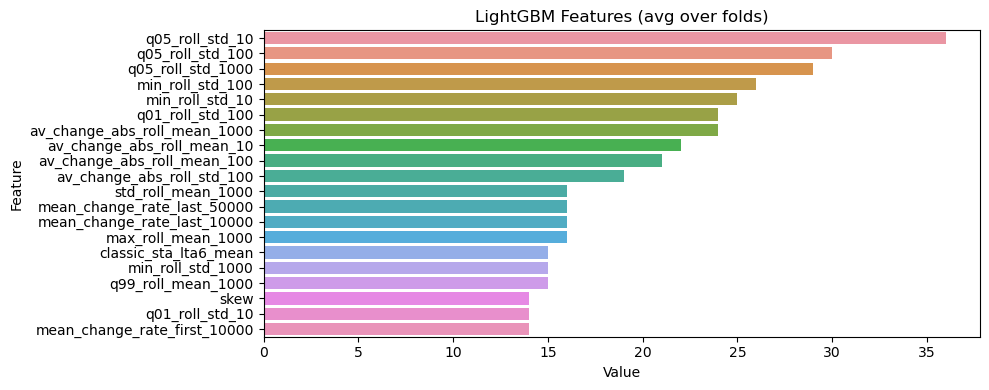

<Figure size 640x480 with 0 Axes>

In [242]:
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# sorted(zip(clf.feature_importances_, X.columns), reverse=True)
feature_imp = pd.DataFrame(sorted(zip(lgb_based.feature_importances_,X_test_lgb_base.columns)), columns=['Value','Feature'])

plt.figure(figsize=(10,4))
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False)[:20])
plt.title('LightGBM Features (avg over folds)')
plt.tight_layout()
plt.show()
plt.savefig('lgbm_importances-01.png')

## Powershap method implementation

In [97]:
# X_train_lgb_base,X_test_lgb_base,y_train_lgb_base,y_test_lgb_base

selector_lgb = PowerShap(
    model = LGBMRegressor(),
    automatic=True,limit_automatic=100,)
selector_lgb.fit(X_train_lgb_base, y_train_lgb_base)


  0%|          | 0/10 [00:00<?, ?it/s]

[1]	valid_0's l2: 12.5119
[2]	valid_0's l2: 11.5703
[3]	valid_0's l2: 10.8027
[4]	valid_0's l2: 10.2027
[5]	valid_0's l2: 9.74085
[6]	valid_0's l2: 9.3491
[7]	valid_0's l2: 9.07596
[8]	valid_0's l2: 8.82205
[9]	valid_0's l2: 8.6477
[10]	valid_0's l2: 8.50329
[11]	valid_0's l2: 8.38734
[12]	valid_0's l2: 8.30603
[13]	valid_0's l2: 8.22202
[14]	valid_0's l2: 8.1605
[15]	valid_0's l2: 8.12941
[16]	valid_0's l2: 8.06997
[17]	valid_0's l2: 8.06934
[18]	valid_0's l2: 8.09103
[19]	valid_0's l2: 8.09704
[20]	valid_0's l2: 8.08458
[21]	valid_0's l2: 8.06676
[22]	valid_0's l2: 8.06079
[23]	valid_0's l2: 8.05718
[24]	valid_0's l2: 8.05617
[25]	valid_0's l2: 8.05664
[26]	valid_0's l2: 8.05736
[27]	valid_0's l2: 8.05872
[28]	valid_0's l2: 8.05804
[29]	valid_0's l2: 8.07525
[30]	valid_0's l2: 8.07173
[31]	valid_0's l2: 8.07833
[32]	valid_0's l2: 8.08585
[33]	valid_0's l2: 8.0723
[34]	valid_0's l2: 8.08728
[35]	valid_0's l2: 8.09452
[36]	valid_0's l2: 8.10204
[37]	valid_0's l2: 8.12099
[38]	valid_0's

  0%|          | 0/1 [00:00<?, ?it/s]

[1]	valid_0's l2: 12.5119
[2]	valid_0's l2: 11.5703
[3]	valid_0's l2: 10.795
[4]	valid_0's l2: 10.1677
[5]	valid_0's l2: 9.7128
[6]	valid_0's l2: 9.35447
[7]	valid_0's l2: 9.04823
[8]	valid_0's l2: 8.7663
[9]	valid_0's l2: 8.59109
[10]	valid_0's l2: 8.48484
[11]	valid_0's l2: 8.35745
[12]	valid_0's l2: 8.27858
[13]	valid_0's l2: 8.19916
[14]	valid_0's l2: 8.12472
[15]	valid_0's l2: 8.07343
[16]	valid_0's l2: 8.03557
[17]	valid_0's l2: 8.03501
[18]	valid_0's l2: 8.01954
[19]	valid_0's l2: 8.02362
[20]	valid_0's l2: 8.00788
[21]	valid_0's l2: 8.01247
[22]	valid_0's l2: 7.98343
[23]	valid_0's l2: 7.98508
[24]	valid_0's l2: 7.98299
[25]	valid_0's l2: 7.98232
[26]	valid_0's l2: 7.96197
[27]	valid_0's l2: 7.9591
[28]	valid_0's l2: 7.93534
[29]	valid_0's l2: 7.9441
[30]	valid_0's l2: 7.94039
[31]	valid_0's l2: 7.95441
[32]	valid_0's l2: 7.94504
[33]	valid_0's l2: 7.94162
[34]	valid_0's l2: 7.92545
[35]	valid_0's l2: 7.94381
[36]	valid_0's l2: 7.95585
[37]	valid_0's l2: 7.97415
[38]	valid_0's 

PowerShap(limit_automatic=100, model=LGBMRegressor(random_seed=10))

In [98]:
selector_lgb._processed_shaps_df

,impact,p_value,effect_size,power_0.01_alpha,0.99_power_its_req
q05_roll_std_10,1.210171580314636,0.000000000000000,-8.768353867471728,1.000000000000000,3.002100288463822
q05_roll_std_100,0.561877012252808,0.000000000000000,-4.710109770261756,1.000000000000000,3.979531407974865
q05_roll_std_1000,0.306414723396301,0.000000000000000,-3.719501210699246,1.000000000000000,4.634896816895105
q01_roll_std_100,0.162036925554276,0.000000000000000,-2.619307547053400,0.999999616547932,6.244125619111822
q01_roll_std_10,0.121220752596855,0.181818181818182,0.000000000000000,0.000000000000000,0.000000000000000
...,...,...,...,...,...
abs_max_roll_std_1000,0.000000000000000,1.000000000000000,0.000000000000000,0.000000000000000,0.000000000000000
abs_max_roll_std_100,0.000000000000000,1.000000000000000,0.000000000000000,0.000000000000000,0.000000000000000
med,0.000000000000000,1.000000000000000,0.000000000000000,0.000000000000000,0.000000000000000
ave_roll_std_1000,0.000000000000000,1.000000000000000,0.000000000000000,0.000000000000000,0.000000000000000


In [99]:
# X_train_lgb_base,X_test_lgb_base,y_train_lgb_base,y_test_lgb_base
X_test_lgb_base_upd=selector_lgb.transform(X_test_lgb_base)


In [103]:
print(X_test_lgb_base_upd.shape)
X_test_lgb_base_upd.info()

(839, 7)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 839 entries, 0 to 838
Data columns (total 7 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   mean_change_rate       839 non-null    float64
 1   classic_sta_lta6_mean  839 non-null    float64
 2   q05_roll_std_10        839 non-null    float64
 3   min_roll_std_100       839 non-null    float64
 4   q01_roll_std_100       839 non-null    float64
 5   q05_roll_std_100       839 non-null    float64
 6   q05_roll_std_1000      839 non-null    float64
dtypes: float64(7)
memory usage: 46.0 KB


In [104]:
X_train_lgb_base_upd = selector_lgb.transform(X_train_lgb_base)

In [105]:
print(X_train_lgb_base_upd.shape)
X_train_lgb_base_upd.info()

(3355, 7)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3355 entries, 0 to 3354
Data columns (total 7 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   mean_change_rate       3355 non-null   float64
 1   classic_sta_lta6_mean  3355 non-null   float64
 2   q05_roll_std_10        3355 non-null   float64
 3   min_roll_std_100       3355 non-null   float64
 4   q01_roll_std_100       3355 non-null   float64
 5   q05_roll_std_100       3355 non-null   float64
 6   q05_roll_std_1000      3355 non-null   float64
dtypes: float64(7)
memory usage: 183.6 KB


In [213]:
X_train_lgb_base_upd.shape,X_test_lgb_base_upd.shape,y_train_lgb_base.shape,y_test_lgb_base.shape

((3355, 7), (839, 7), (3355, 1), (839, 1))

## Hyperparameter optimzation

In [218]:
grid_params = {
                "n_estimators":[1000,3000,5000,10000],
                "learning_rate":[0.01,0.05],
                "num_leaves":[10,15,20]
}

In [219]:
 lgb_model_ho = LGBMRegressor()

In [220]:
from sklearn.model_selection import GridSearchCV
grid = GridSearchCV(estimator=lgb_model_ho, param_grid = grid_params, cv = 10, n_jobs=-1,verbose=2)
grid.fit(X_train_lgb_base_upd, y_train_lgb_base)

Fitting 10 folds for each of 24 candidates, totalling 240 fits
[CV] END learning_rate=0.01, n_estimators=1000, num_leaves=10; total time=   1.9s
[CV] END learning_rate=0.01, n_estimators=1000, num_leaves=10; total time=   1.8s
[CV] END learning_rate=0.01, n_estimators=1000, num_leaves=10; total time=   1.9s
[CV] END learning_rate=0.01, n_estimators=1000, num_leaves=10; total time=   2.5s
[CV] END learning_rate=0.01, n_estimators=1000, num_leaves=10; total time=   1.8s
[CV] END learning_rate=0.01, n_estimators=1000, num_leaves=10; total time=   1.8s
[CV] END learning_rate=0.01, n_estimators=1000, num_leaves=10; total time=   1.8s
[CV] END learning_rate=0.01, n_estimators=1000, num_leaves=10; total time=   1.8s
[CV] END learning_rate=0.01, n_estimators=1000, num_leaves=10; total time=   1.9s
[CV] END learning_rate=0.01, n_estimators=1000, num_leaves=10; total time=   1.8s
[CV] END learning_rate=0.01, n_estimators=1000, num_leaves=15; total time=   2.6s
[CV] END learning_rate=0.01, n_esti

GridSearchCV(cv=10, estimator=LGBMRegressor(), n_jobs=-1,
             param_grid={'learning_rate': [0.01, 0.05],
                         'n_estimators': [1000, 3000, 5000, 10000],
                         'num_leaves': [10, 15, 20]},
             verbose=2)

In [221]:

print(" Results from Grid Search " )
print("\n The best estimator across ALL searched params:\n", grid.best_estimator_)
print("\n The best score across ALL sear ched params:\n", grid.best_score_)
print("\n The best parameters across ALL searched params:\n", grid.best_params_)


 Results from Grid Search 

 The best estimator across ALL searched params:
 LGBMRegressor(learning_rate=0.01, n_estimators=1000, num_leaves=10)

 The best score across ALL searched params:
 0.4560898925212036

 The best parameters across ALL searched params:
 {'learning_rate': 0.01, 'n_estimators': 1000, 'num_leaves': 10}


In [223]:
final_model = lgb_model_ho.set_params(**grid.best_params_)

In [224]:
final_model.fit(X_train_lgb_base_upd,y_train_lgb_base)

LGBMRegressor(learning_rate=0.01, n_estimators=1000, num_leaves=10)

In [225]:
y_pred_lgb_ho =final_model.predict(X_test_lgb_base_upd)
mae_lgbm_ho = mean_absolute_error(y_test_lgb_base,y_pred_lgb_ho)
mape_lgbm_ho=mean_absolute_percentage_error(y_test_lgb_base,y_pred_lgb_ho)
print('MAE is %.5f' % mae_lgbm_ho)
print('MAPE is %.5f' % mape_lgbm_ho)

MAE is 2.09190
MAPE is 3.75294
